<a href="https://colab.research.google.com/github/JungAh12/Everyone_TF2.0/blob/master/Basic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q seaborn
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 28kB/s 
     |████████████████████████████████| 501kB 60.1MB/s 
     |████████████████████████████████| 4.3MB 44.5MB/s 


#회귀 문제
회귀는 가격이나 확률같이 연속된 값을 예측하는 것이 목적이다.

분류의 경우 여러개의 클래스 중에 하나의 클래스를 선택하는 것이다.

Auto MPG dataset을 사용하여 1970 후반 - 1980 초반의 자동차 연비를 예측하는 모델을 만든다.

In [0]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns   #산점도 행렬을 그리기 위해서 사용하는 패키지

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0-rc1


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [29]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path    # dataset은 UCI ML Archive에서 다운로드.

'/root/.keras/datasets/auto-mpg.data'

feature는 MPG, Cylinders, Displacement, Horsepower, Weight, Acceleration, Model Year, Origin이다.

* MPG : 자동차 연비
* Cylinders : 엔진
* Displacemnet : 배기량
* Horsepower : 마력
* Weight : 무게
* Acceleration : 자동차 가속
* Model Year : 연식
* Origin : 기원(?)


In [30]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [31]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()  # 결측치 drop, Horsepower가 누락된 6개 sample 삭제


In [28]:
#Origin의 값을 one-hot으로 표현 (1)
dataset['Origin'] = dataset['Origin'].map(lambda x: {1:'USA', 2:'Europe',3:'Japan'}.get(x))
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [33]:
#Origin의 값을 one-hot으로 표현 (1)
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index) # train data 제외한 나머지 data는 test data

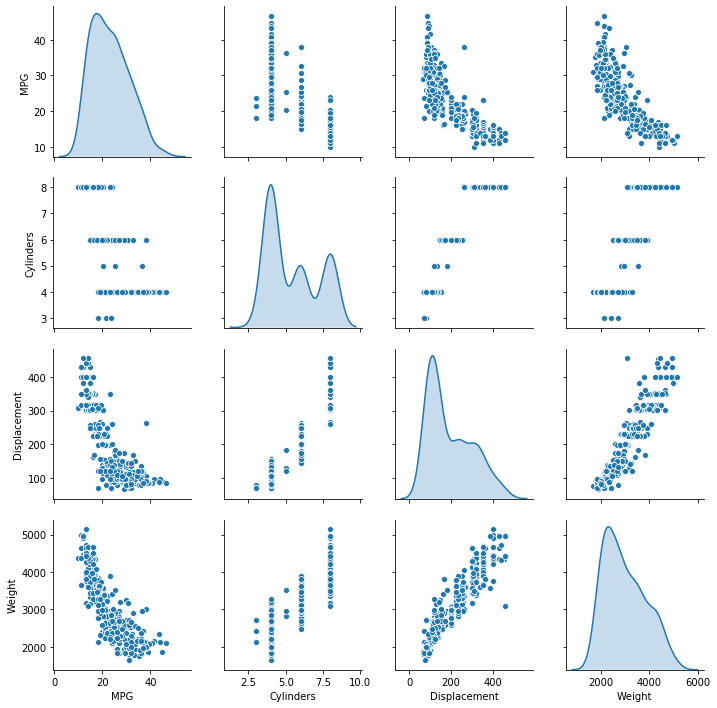

In [35]:
#산점도 행렬 만들기
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")    #diag_kind="kde"는 커널 밀도 히스토그램을 그린다는 의미.

In [36]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [0]:
#MPG feature drop, MPG를 타겟으로 사용하여 분리한다.
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
#data Normalization
#(값-평균)/표준편차
def norm(x):
    return (x - train_stats['mean'])/train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
#Model
def build_model():
    model = keras.Sequential([
                              layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [0]:
model = build_model()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


In [44]:
example_batch = normed_train_data[:10]  # sample batch size = 10
print(normed_train_data[:10])
example_result = model.predict(example_batch)
example_result  # predicted MPG

     Cylinders  Displacement  Horsepower  ...       USA    Europe     Japan
146  -0.869348     -1.009459   -0.784052  ...  0.774676 -0.465148 -0.495225
282  -0.869348     -0.530218   -0.442811  ...  0.774676 -0.465148 -0.495225
69    1.483887      1.482595    1.447140  ...  0.774676 -0.465148 -0.495225
378  -0.869348     -0.865687   -1.099044  ...  0.774676 -0.465148 -0.495225
331  -0.869348     -0.942365   -0.994047  ... -1.286751 -0.465148  2.012852
257   0.307270      0.351586   -0.390312  ...  0.774676 -0.465148 -0.495225
310  -0.869348     -1.019044   -1.177792  ... -1.286751 -0.465148  2.012852
328  -0.869348     -0.472709   -0.994047  ... -1.286751  2.143005 -0.495225
125   0.307270      0.025702   -0.259066  ...  0.774676 -0.465148 -0.495225
108  -0.869348     -0.942365   -0.442811  ... -1.286751 -0.465148  2.012852

[10 rows x 9 columns]


array([[-0.36558735],
       [-0.25391132],
       [-0.15384582],
       [-0.31288376],
       [-0.3726441 ],
       [-0.13678832],
       [-0.3980939 ],
       [-0.7824358 ],
       [-0.18309696],
       [-0.32811058]], dtype=float32)

In [45]:
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:582.7216,  mae:22.8115,  mse:582.7217,  val_loss:570.6939,  val_mae:22.4952,  val_mse:570.6940,  
....................................................................................................
Epoch: 100, loss:5.5196,  mae:1.6555,  mse:5.5196,  val_loss:10.3030,  val_mae:2.3096,  val_mse:10.3030,  
....................................................................................................
Epoch: 200, loss:4.9141,  mae:1.5104,  mse:4.9141,  val_loss:8.8982,  val_mae:2.2336,  val_mse:8.8982,  
....................................................................................................
Epoch: 300, loss:4.1689,  mae:1.3927,  mse:4.1689,  val_loss:9.9144,  val_mae:2.2864,  val_mse:9.9144,  
....................................................................................................
Epoch: 400, loss:4.3779,  mae:1.4275,  mse:4.3779,  val_loss:10.4585,  val_mae:2.3610,  val_mse:10.4585,  
..........................................................

In [47]:
# history에 저장된 통계치를 사용해서 훈련 과정을 시각화해보자.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.553680,0.865149,1.553680,10.308008,2.387551,10.308008,995
996,1.902370,0.974688,1.902370,10.256336,2.424590,10.256336,996
997,1.896403,0.991877,1.896403,11.404309,2.441960,11.404308,997
998,1.535030,0.855069,1.535030,10.773864,2.542979,10.773865,998
999,2.012105,1.080578,2.012105,10.762102,2.563366,10.762102,999


Text(0, 0.5, 'MAE [MPG]')

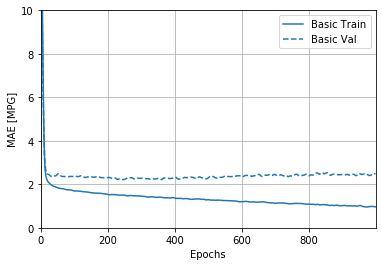

In [48]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic':history}, metric='mae')
plt.ylim([0,10])
plt.ylabel('MAE [MPG]') #Mean Absolute Error

Text(0, 0.5, 'MSE [MPG^2]')

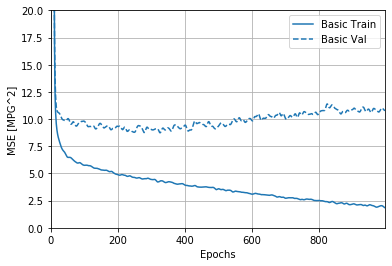

In [49]:
plotter.plot({'Basic':history}, metric = 'mse')
plt.ylim([0,20])
plt.ylabel('MSE [MPG^2]')

In [51]:
model = build_model()
#patience는 성능향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_history = model.fit(normed_train_data, train_labels,
                          epochs=EPOCHS, validation_split=0.2, verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:537.0556,  mae:21.7843,  mse:537.0557,  val_loss:487.4493,  val_mae:20.4888,  val_mse:487.4493,  
....................................

Text(0, 0.5, 'MAE [MPG]')

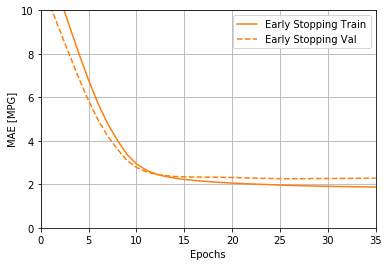

In [52]:
plotter.plot({'Early Stopping':early_history}, metric='mae')
plt.ylim([0,10])
plt.ylabel('MAE [MPG]')

In [53]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set MEAN ABS ERROR: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 8.8944 - mae: 2.3882 - mse: 8.8944
Testing set MEAN ABS ERROR:  2.39 MPG


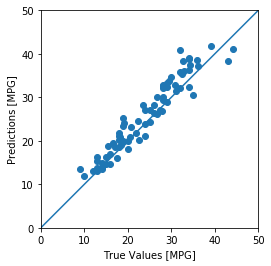

In [54]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

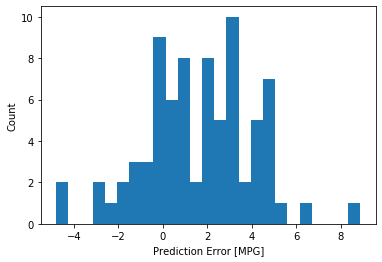

In [55]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

회귀에서 많이 사용하는 평가 지표는 **MAE**이다.

수치 입력 데이터의 feature가 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성들의 스케일을 독립적으로 조정해야한다.

MSE는 회귀에서 자주 사용하는 손실 함수이다.

훈련 데이터가 적으면 overfitting을 피하기 위해 소규모 네트워크를 만드는 것이 좋다.

조기 종료가 overfitting을 막는 방법이 될 수 있다.